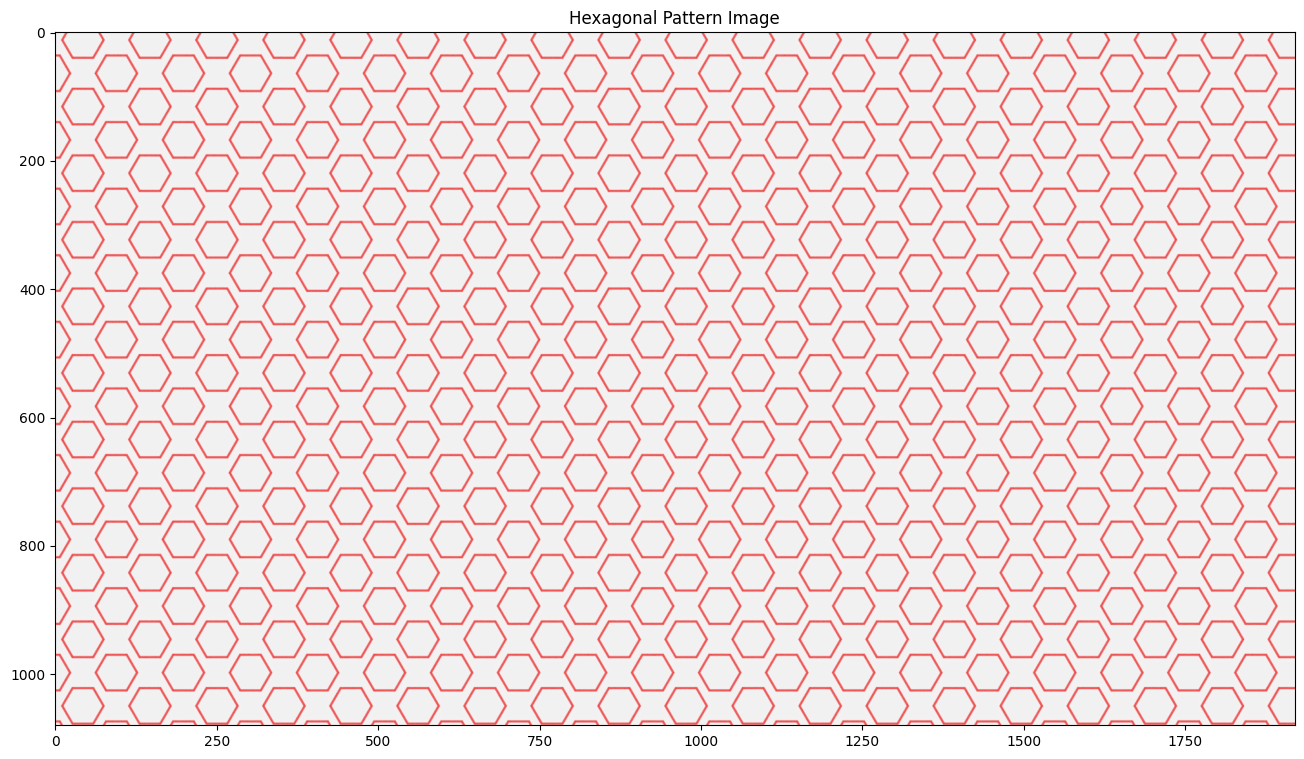

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Path to the pickle file
file_path = 'Images/hex_img_data.pkl'

try:
    # Load the pickle file
    with open(file_path, 'rb') as f:
        raw_data = pickle.load(f)

    if isinstance(raw_data, pd.DataFrame):
        # Extract the single cell value and check its type
        cell_data = raw_data.iloc[0, 0]  # Access the single cell

        # If the cell contains an array-like structure, reshape it
        if isinstance(cell_data, np.ndarray):
            image_data = cell_data  # Use directly if it's already a NumPy array
        else:
            # Try to convert to a NumPy array
            image_data = np.array(cell_data)

        # Validate the shape of the image data
        if len(image_data.shape) == 1:
            # If 1D, assume square and reshape (if possible)
            side_length = int(np.sqrt(len(image_data)))
            image_data = image_data.reshape((side_length, side_length))

        # Display the hexagonal image
        plt.figure(figsize=(16, 9))
        plt.imshow(image_data, cmap='viridis', aspect='auto')
        plt.title("Hexagonal Pattern Image")
        plt.show()
    else:
        print("The loaded data is not a DataFrame.")
except Exception as e:
    print(f"An error occurred: {e}")
